In [2]:
import os
from natsort import natsorted
import pandas as pd
from tqdm import tqdm
import numpy as np
import warnings

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수(-1 예측 포함)
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle if rle != '' else -1

In [4]:
class Ensemble:
    """
    folder_path: csv 파일이 있는 폴더의 경로 입력. csv 파일만 선택하므로 다른 파일이 포함되어 있어도 상관 없음.
    block_size: 60000개의 row를 한 번에 처리할 수 없어 작은 size로 분해해 처리, 단 저장 공간 10G 이상 필요.
    img_shape: encoding할 image shape (224, 224)
    temp_folder: 작게 쪼갠 파일을 임시로 저장할 폴더 경로 입력. 없는 경로라면 자동 생성하여 저장.
    """
    def __init__(self, folder_path, block_size, img_shape = (224, 224), temp_folder="../temp/"):
        self.folder_path = folder_path
        self.df_list = [pd.read_csv(folder_path + "/" + csv_file) for csv_file in natsorted(os.listdir(folder_path)) if 'csv' in csv_file]
        print(len(self.df_list))
        self.img_shape = img_shape
        self.block_size = block_size
        self.row_len = len(self.df_list[0])
        self.temp_folder = temp_folder
        self.num_blocks = self.row_len // self.block_size + 1
        os.makedirs(self.temp_folder, exist_ok=True)

    def process_df(self, df):
        return np.stack(df['mask_rle'].apply(lambda x: rle_decode(x, self.img_shape)))
    
    def save_temp_data(self, data, index):
        if not os.path.exists(self.temp_folder):
            os.makedirs(self.temp_folder)
        file_path = os.path.join(self.temp_folder, f"temp_data_{index}.npy")
        np.save(file_path, data)

    def load_temp_data(self, index):
        file_path = os.path.join(self.temp_folder, f"temp_data_{index}.npy")
        return np.load(file_path)

    def hard_voting(self):
        total_list = []
        print("Voting 및 csv 분할하는 중..")
        for i in tqdm(range(self.num_blocks)):
            temp_list = []
            start_idx = i * self.block_size
            end_idx = start_idx + self.block_size if start_idx + self.block_size < self.row_len else self.row_len
            for df in self.df_list:
                temp_list.append(self.process_df(df[start_idx:end_idx]))
            self.save_temp_data(np.where(np.mean(temp_list, axis = 0) >= 0.5, 1, 0), i)
            total_list.append(i)
        result_list = []
        print("**메모리 사용량 주의**")
        print("csv를 합치는 중..")
        for i in tqdm(total_list):
            temp_data = self.load_temp_data(i)
            result_list.extend(temp_data)
        print("rle_encode 중..")
        result_list = list(map(rle_encode, result_list))
        print("완료!")
        return result_list
    
    def union(self):
        total_list = []
        print("Union 및 csv 분할하는 중..")
        for i in tqdm(range(self.num_blocks)):
            temp_list = []
            start_idx = i * self.block_size
            end_idx = start_idx + self.block_size if start_idx + self.block_size < self.row_len else self.row_len
            for df in self.df_list:
                temp_list.append(self.process_df(df[start_idx:end_idx]))
            self.save_temp_data((np.sum(temp_list, axis = 0) > 0).astype(np.uint8), i)
            total_list.append(i)
        result_list = []
        print("**메모리 사용량 주의**")
        print("csv를 합치는 중..")
        for i in tqdm(total_list):
            temp_data = self.load_temp_data(i)
            result_list.extend(temp_data)
        print("rle_encode 중..")
        result_list = list(map(rle_encode, result_list))
        print("완료!")
        return result_list

# 개별 설정

In [6]:
folder_path = './minseo/data/ensamble/' # csv 파일이 있는 폴더의 경로 입력. csv 파일만 선택하므로 다른 파일이 포함되어 있어도 상관 없음.
temp_folder = "./minseo/data/temp" # 계산하여 분할 저장할 파일의 경로
submit_path = "./minseo/data/ensemble_result" # 저장할 경로 지정. 없어도 만들어주니까 괜찮음.
img_shape = (224, 224) # encoding할 image shape
block_size = 10000 # 60000개의 row를 한 번에 처리할 수 없어 작은 size로 분해해 처리. 이게 클수록 메모리 소모 큼. 저장 공간 10G 이상 필요.
ens = Ensemble(folder_path=folder_path, img_shape=(224, 224), block_size=block_size, temp_folder=temp_folder)

8


# 작동

In [7]:
# ens_result = ens.union()
ens_result = ens.hard_voting()

Voting 및 csv 분할하는 중..


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [07:53<00:00, 67.62s/it]


**메모리 사용량 주의**
csv를 합치는 중..


100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


rle_encode 중..
완료!


In [29]:
import datetime
import matplotlib.pyplot as plt
submit = pd.read_csv("./minseo/data/sample_submission.csv") # sample_submission.csv 경로 지정
submit['mask_rle'] = ens_result

now = datetime.datetime.now()
current_time = now.strftime("ens_%m%d-%H_%M_%S")
file_name = f"{current_time}.csv"
if not os.path.exists(submit_path):
    os.makedirs(submit_path)
submit_path = f"{submit_path}/{file_name}"
submit.to_csv(submit_path, index=False)

# 앙상블 결과 확인

In [13]:
def plot_res(df_list, result, idx):
    warnings.filterwarnings("ignore", category=UserWarning)
    df_file_list = [row1[0] for row1 in df_list]
    df_name_list = [row2[1] for row2 in df_list]
    temp_list = []
    fig = plt.figure(figsize=[20 * (int(len(df_file_list) / 4) + 1),20])
    for df in df_file_list:
        temp_list.append(rle_decode(df.iloc[idx,1], (224,224)))
    temp_list.append(rle_decode(result.iloc[idx,1], (224,224)))

    for i in range(len(temp_list)):
        ax1 = fig.add_subplot(int(len(df_file_list) / 4) + 1,4,i+1)
        ax1.imshow(temp_list[i],cmap='gray')
        ax1.tick_params(axis='both', labelsize=16)
        if i == len(temp_list) - 1:
            ax1.set_title(f'Ensemble Result', fontsize=20)
        else:
            ax1.set_title(f'{df_name_list[i]}', fontsize=20)

In [30]:
df_list = [[pd.read_csv(folder_path + "/" + csv_file), csv_file] for csv_file in natsorted(os.listdir(folder_path)) if 'csv' in csv_file]
result = pd.read_csv(submit_path)

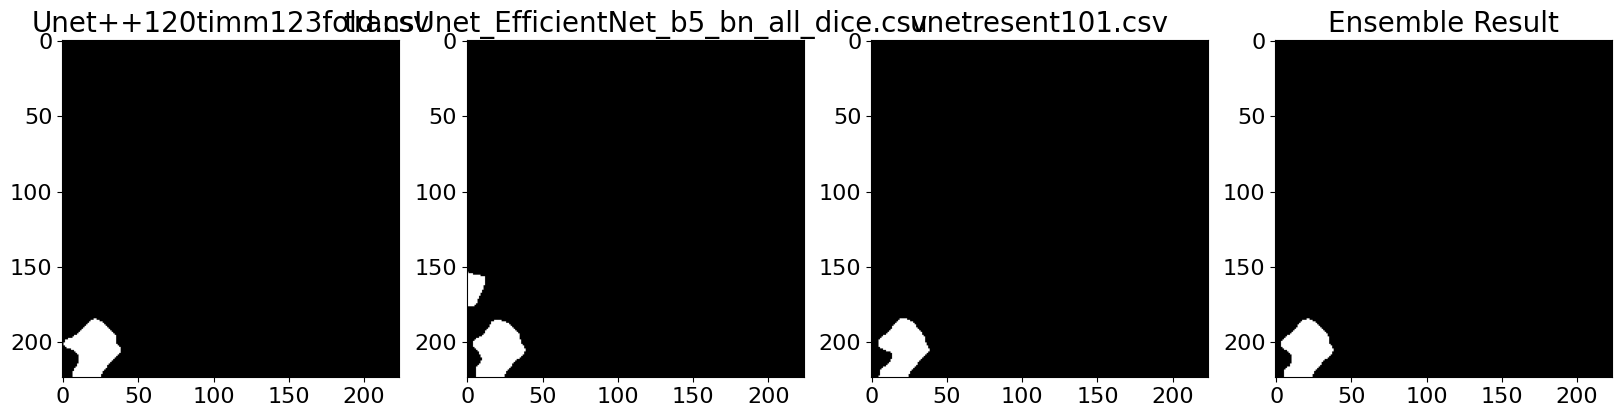

In [31]:
plot_res(df_list, result, 10) # 몇 번 테스트 파일을 볼 것인지

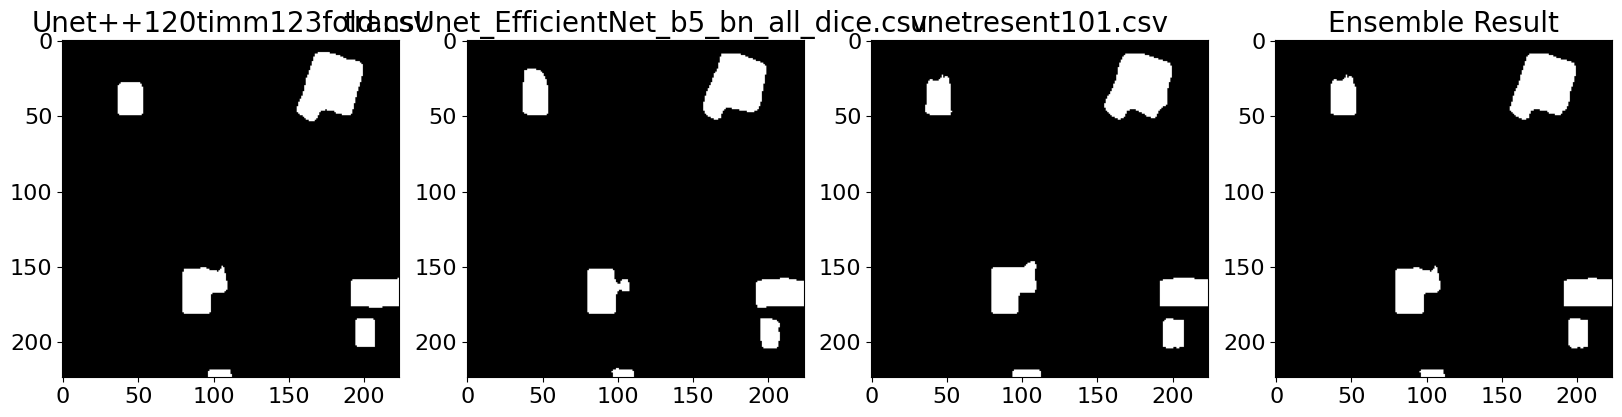

In [32]:
plot_res(df_list, result, 20) # 몇 번 테스트 파일을 볼 것인지